## 1. Imports

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (15, 6)

## 2. Data Loading

Loading the two datasets and parsing timestamps.

In [ ]:
df_trans = pd.read_csv('sample_data/transactions/transactions.csv', parse_dates=['timestamp'])
df_auth = pd.read_csv('sample_data/transactions/transactions_auth_codes.csv', parse_dates=['timestamp'])

df_trans = df_trans.sort_values('timestamp')
df_auth = df_auth.sort_values('timestamp')

print(f"Transactions Data: {df_trans.shape[0]} rows, Time range: {df_trans['timestamp'].min()} to {df_trans['timestamp'].max()}")
print(f"Auth Codes Data: {df_auth.shape[0]} rows, Time range: {df_auth['timestamp'].min()} to {df_auth['timestamp'].max()}")


Transactions Data: 25920 rows, Time range: 2025-07-12 13:45:00 to 2025-07-15 13:44:00
Auth Codes Data: 12960 rows, Time range: 2025-07-12 13:45:00 to 2025-07-15 13:44:00


### 2.1 Transactions data sanity checks

In [ ]:

print(f"Null Values:\n{df_trans.isnull().sum()}")
print(f"Duplicate Timestamps: {df_trans['timestamp'].duplicated().sum()}")
print(f"Negative Counts: {(df_trans['count'] < 0).sum()}")
print(f"Unique Statuses: {df_trans['status'].unique()}")

expected_range = pd.date_range(start=df_trans['timestamp'].min(), end=df_trans['timestamp'].max(), freq='1min')
missing_timestamps = expected_range.difference(df_trans['timestamp'])
print(f"Missing Timestamps: {len(missing_timestamps)}")

Null Values:
timestamp    0
status       0
count        0
dtype: int64
Duplicate Timestamps: 21600
Negative Counts: 0
Unique Statuses: <StringArray>
['approved', 'backend_reversed', 'reversed', 'refunded', 'denied', 'failed']
Length: 6, dtype: str
Missing Timestamps: 0


### 2.2 Auth codes data sanity checks

In [21]:
print(f"Shape: {df_auth.shape}")
print(f"Null Values:\n{df_auth.isnull().sum()}")
print(f"Duplicate Combinations: {df_auth.duplicated(subset=['timestamp', 'auth_code']).sum()}")
print(f"Negative Counts: {(df_auth['count'] < 0).sum()}")
print(f"Unique Auth Codes: {df_auth['auth_code'].unique()}")

Shape: (12960, 3)
Null Values:
timestamp    0
auth_code    0
count        0
dtype: int64
Duplicate Combinations: 0
Negative Counts: 0
Unique Auth Codes: [ 0 51 59]


### 2.3 Cross validate data

In [22]:
total_trans_counts = df_trans.groupby('timestamp')['count'].sum()
total_auth_counts = df_auth.groupby('timestamp')['count'].sum()
print(f"Timestamps with Mismatched Total Counts: {(total_trans_counts != total_auth_counts).sum()}")

Timestamps with Mismatched Total Counts: 3757


### 2.4 Verify Inconsistency Between Transactions and Auth Codes

In [25]:
print("Unique Statuses in Transactions:", df_trans['status'].unique())
print("Unique Auth Codes in Auth Codes:", df_auth['auth_code'].unique())

df_trans_filtered = df_trans[df_trans['status'].isin(['approved', 'denied'])]
trans_sums_filtered = df_trans_filtered.groupby('timestamp')['count'].sum()
auth_sums = df_auth.groupby('timestamp')['count'].sum()

print(trans_sums_filtered.sum())
print(auth_sums.sum())

mismatches_filtered = trans_sums_filtered != auth_sums
mismatched_indices_filtered = mismatches_filtered[mismatches_filtered].index

print(f"Number of mismatched timestamps after filtering for approved/denied: {len(mismatched_indices_filtered)}")

if len(mismatched_indices_filtered) > 0:
    print("Hypothesis failing. Showing first mismatch:")
    sample_ts = mismatched_indices_filtered[0]
    print(f"Timestamp: {sample_ts}")
    print(f"Filtered Trans Sum: {trans_sums_filtered.loc[sample_ts]}")
    print(f"Auth Sum: {auth_sums.loc[sample_ts]}")
else:
    print("Hypothesis confirmed: 'transactions' filtered for 'approved' and 'denied' matches 'auth_codes' totals perfectly.")

Unique Statuses in Transactions: <StringArray>
['approved', 'backend_reversed', 'reversed', 'refunded', 'denied', 'failed']
Length: 6, dtype: str
Unique Auth Codes in Auth Codes: [ 0 51 59]
534579
534579
Number of mismatched timestamps after filtering for approved/denied: 0
Hypothesis confirmed: 'transactions' filtered for 'approved' and 'denied' matches 'auth_codes' totals perfectly.


## 2.5 Conclusion

Data is consistent and already cleaned. No need to engineer the data.
Transactions match auth codes when filtered for 'approved' and 'denied' statuses.
- Transactions sum: 25920
- Auth codes sum: 25920

## 3. Timestamp Analysis (Domain Clarification)

We visualize the *entire* timestamp range to understand the data's duration and continuity. This helps identify:
- **Business Cycles**: Daily peaks and valleys.
- **Data Gaps**: Missing periods which might indicate outages or logging failures.
- **Anomalies**: Sudden spikes or drops in overall volume.

<Figure size 1800x600 with 0 Axes>

Text(0.5, 1.0, 'Total Transaction Volume over Time (Per Minute)')

Text(0.5, 0, 'Timestamp')

Text(0, 0.5, 'Transactions per Minute')

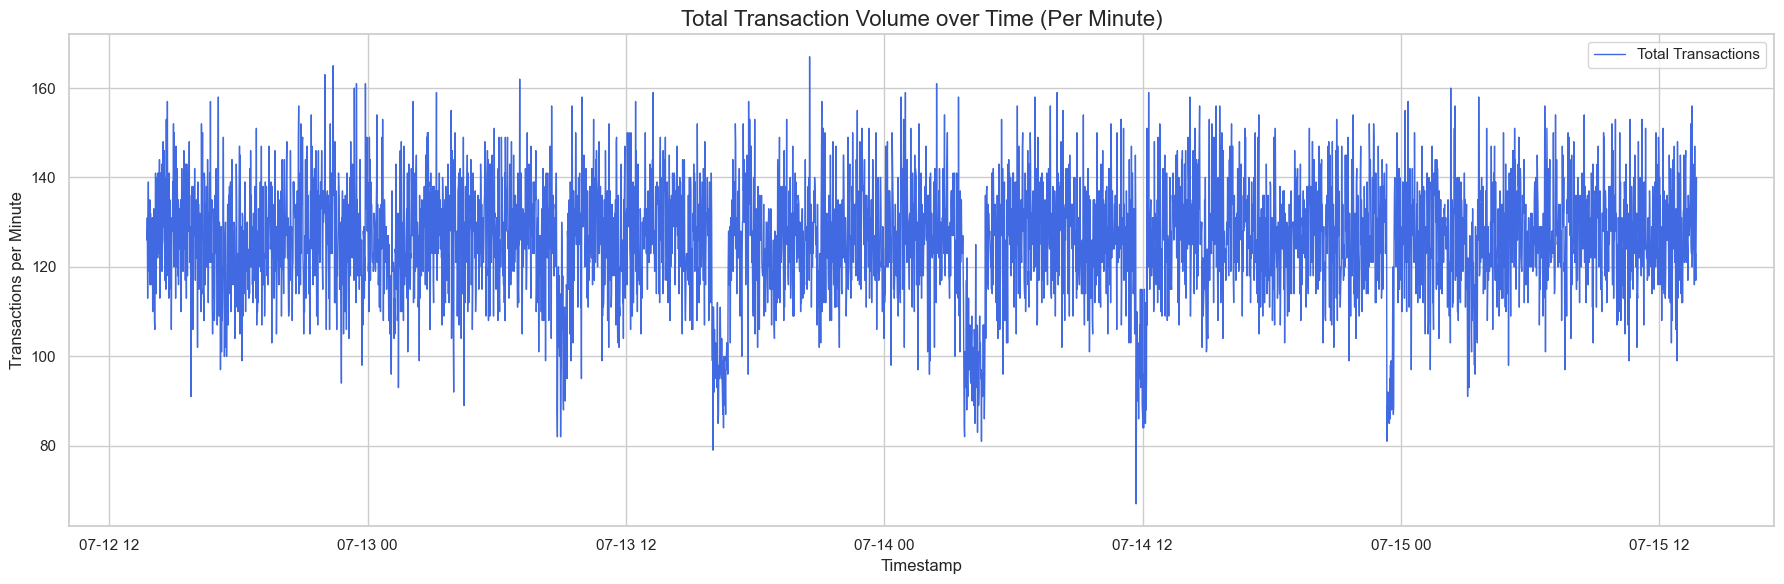

In [5]:
# Aggregating total volume per minute across all statuses for a cleaner view
total_volume_per_minute = df_trans.groupby('timestamp')['count'].sum().reset_index()

plt.figure(figsize=(18, 6))
plt.plot(total_volume_per_minute['timestamp'], total_volume_per_minute['count'], label='Total Transactions', color='royalblue', linewidth=1)
plt.title('Total Transaction Volume over Time (Per Minute)', fontsize=16)
plt.xlabel('Timestamp')
plt.ylabel('Transactions per Minute')
plt.legend()
plt.tight_layout()
plt.show()

**Observation:**
The plot above shows the full timeline of the dataset. 

## 4. Status Distribution Analysis

Analyzing the distribution of transaction statuses (`approved`, `declined`, etc.).

<Figure size 1200x500 with 0 Axes>

C:\Users\David\AppData\Local\Temp\ipykernel_47248\3331884734.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=status_counts.index, y=status_counts.values, palette='viridis')


<Axes: xlabel='status'>

Text(0.5, 1.0, 'Total Transaction Volume by Status')

Text(0, 0.5, 'Total Count')

Text(0.5, 0, 'Status')

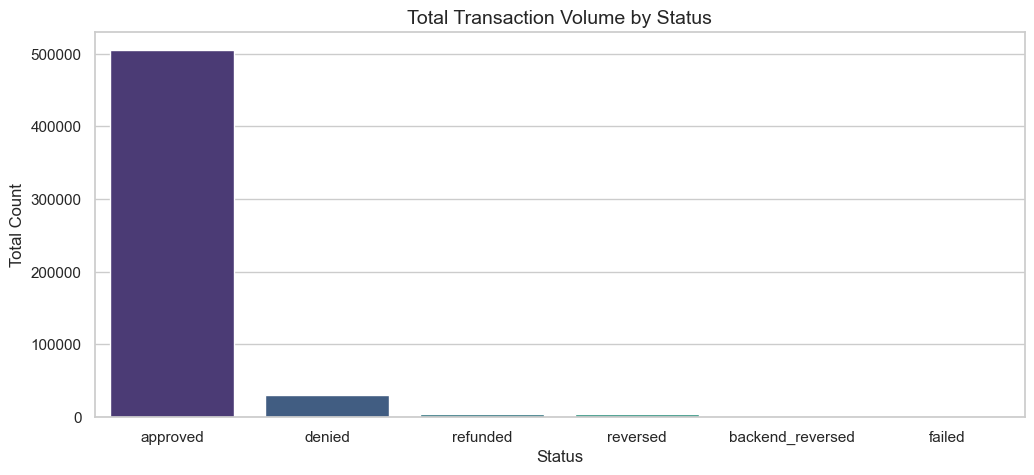

In [6]:
# Total count by status
status_counts = df_trans.groupby('status')['count'].sum().sort_values(ascending=False)

plt.figure(figsize=(12, 5))
sns.barplot(x=status_counts.index, y=status_counts.values, palette='viridis')
plt.title('Total Transaction Volume by Status', fontsize=14)
plt.ylabel('Total Count')
plt.xlabel('Status')
plt.show()

<Figure size 1800x600 with 0 Axes>

Text(0.5, 1.0, 'Transaction Status Volume over Time')

Text(0.5, 0, 'Timestamp')

Text(0, 0.5, 'Count')

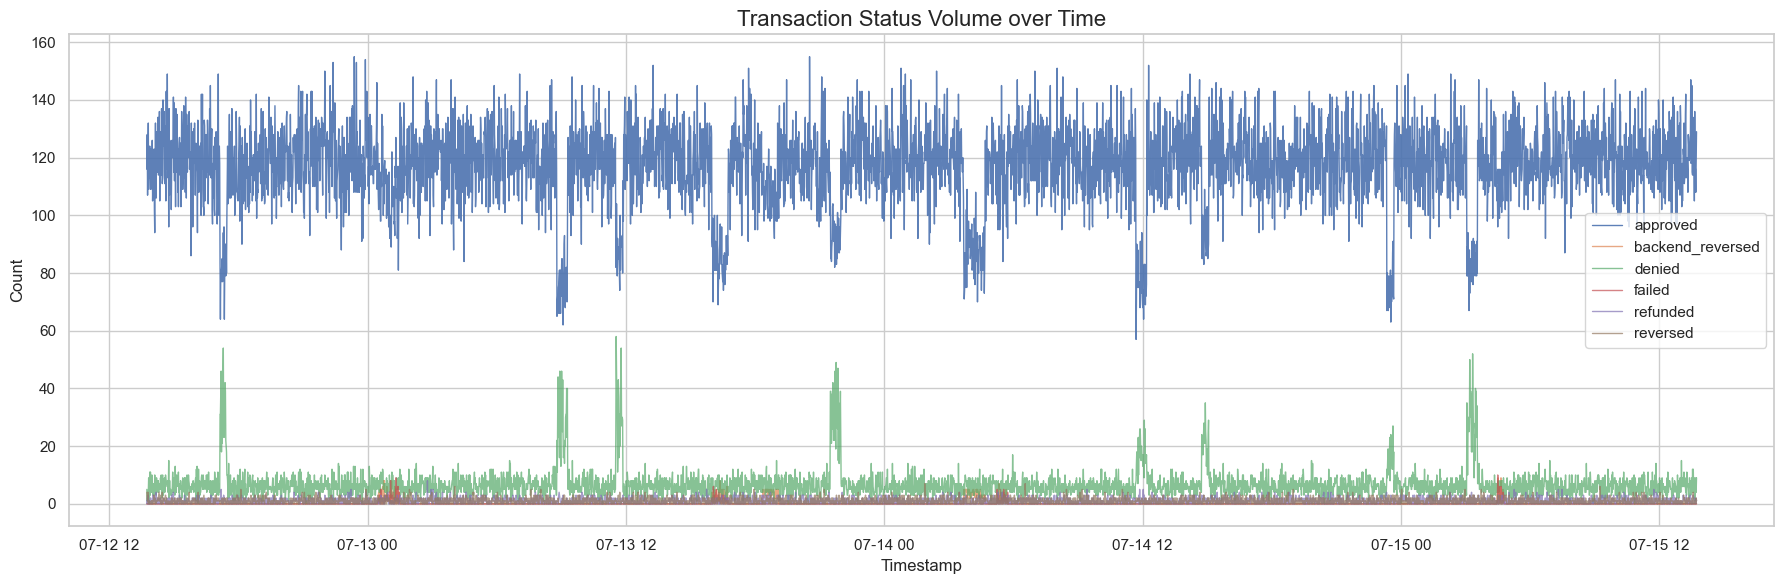

In [7]:
# Time series of statuses
status_pivot = df_trans.pivot_table(index='timestamp', columns='status', values='count', aggfunc='sum', fill_value=0)

plt.figure(figsize=(18, 6))
for column in status_pivot.columns:
    if column == 'approved':
        # Use a thicker line or distinct color for approved as it's the main volume
        plt.plot(status_pivot.index, status_pivot[column], label=column, linewidth=1, alpha=0.9)
    else:
        plt.plot(status_pivot.index, status_pivot[column], label=column, linewidth=1, alpha=0.7)

plt.title('Transaction Status Volume over Time', fontsize=16)
plt.xlabel('Timestamp')
plt.ylabel('Count')
plt.legend()
plt.tight_layout()
plt.show()

## 5. Approval Rate Analysis

The Approval Rate is a key KPI. A sudden drop in approval rate often indicates a system issue or a fraud attack.
$$ \text{Approval Rate} = \frac{\text{Approved Count}}{\text{Total Count}} $$

<Figure size 1800x600 with 0 Axes>

Text(0.5, 1.0, 'Approval Rate over Time')

Text(0, 0.5, 'Approval Rate (0.0 - 1.0)')

Text(0.5, 0, 'Timestamp')

(0.0, 1.1)

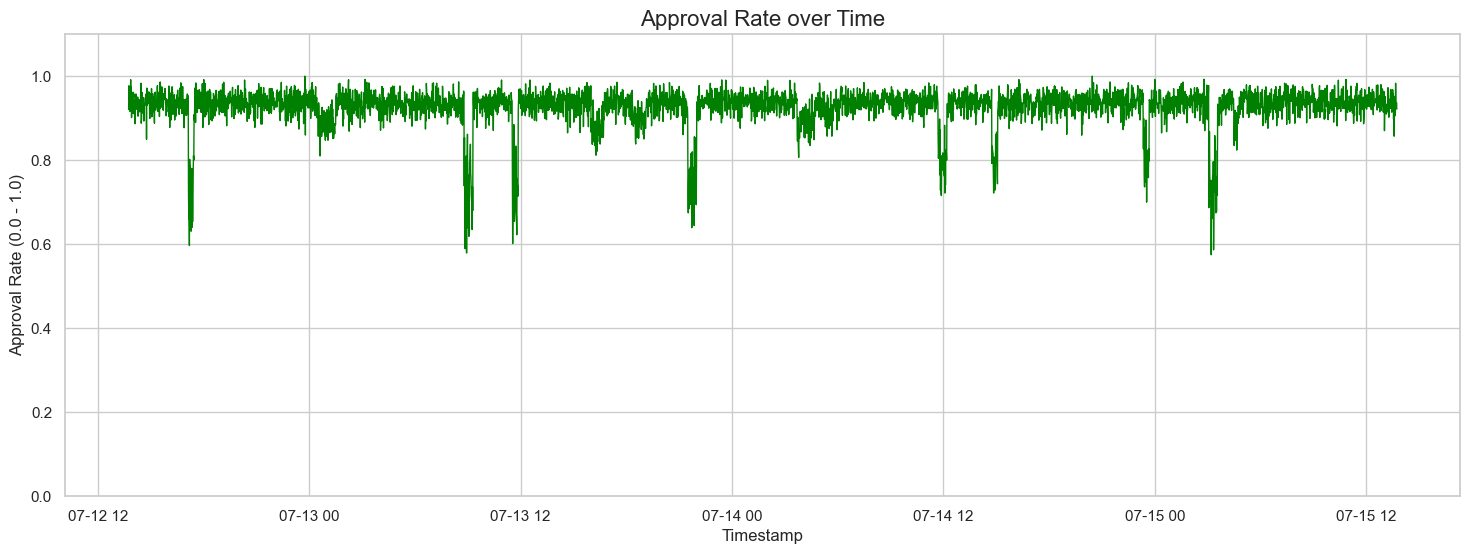

In [8]:
# Calculate Total and Approved counts per timestamp
volume_per_ts = df_trans.groupby('timestamp')['count'].sum()
approved_per_ts = df_trans[df_trans['status'] == 'approved'].groupby('timestamp')['count'].sum()

approval_rate = (approved_per_ts / volume_per_ts).fillna(0)

plt.figure(figsize=(18, 6))
plt.plot(approval_rate.index, approval_rate.values, color='green', linewidth=1)
plt.title('Approval Rate over Time', fontsize=16)
plt.ylabel('Approval Rate (0.0 - 1.0)')
plt.xlabel('Timestamp')
plt.ylim(0, 1.1)  # Fix y-axis to 0-100%
plt.show()

## 6. Authorization Code Analysis

Examining specific return codes to understand *why* transactions are failing.

<Figure size 1200x500 with 0 Axes>

C:\Users\David\AppData\Local\Temp\ipykernel_47248\2595090940.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=auth_counts.index.astype(str), y=auth_counts.values, palette='magma')


<Axes: xlabel='auth_code'>

Text(0.5, 1.0, 'Top 10 Authorization Codes by Volume')

Text(0, 0.5, 'Total Count')

Text(0.5, 0, 'Auth Code')

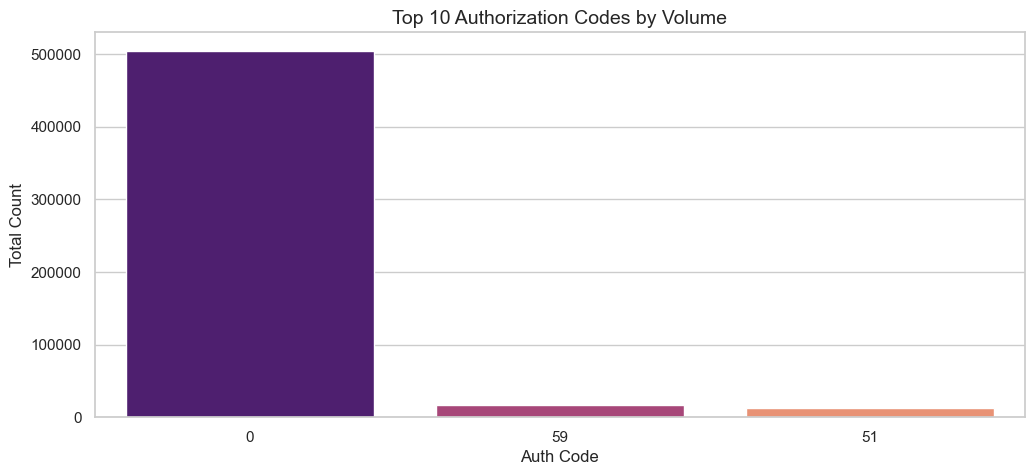

In [9]:
# Top 10 Auth Codes
auth_counts = df_auth.groupby('auth_code')['count'].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(12, 5))
sns.barplot(x=auth_counts.index.astype(str), y=auth_counts.values, palette='magma')
plt.title('Top 10 Authorization Codes by Volume', fontsize=14)
plt.ylabel('Total Count')
plt.xlabel('Auth Code')
plt.show()

<Figure size 1800x600 with 0 Axes>

Text(0.5, 1.0, 'Top 5 Error/Decline Codes over Time')

Text(0.5, 0, 'Timestamp')

Text(0, 0.5, 'Count')

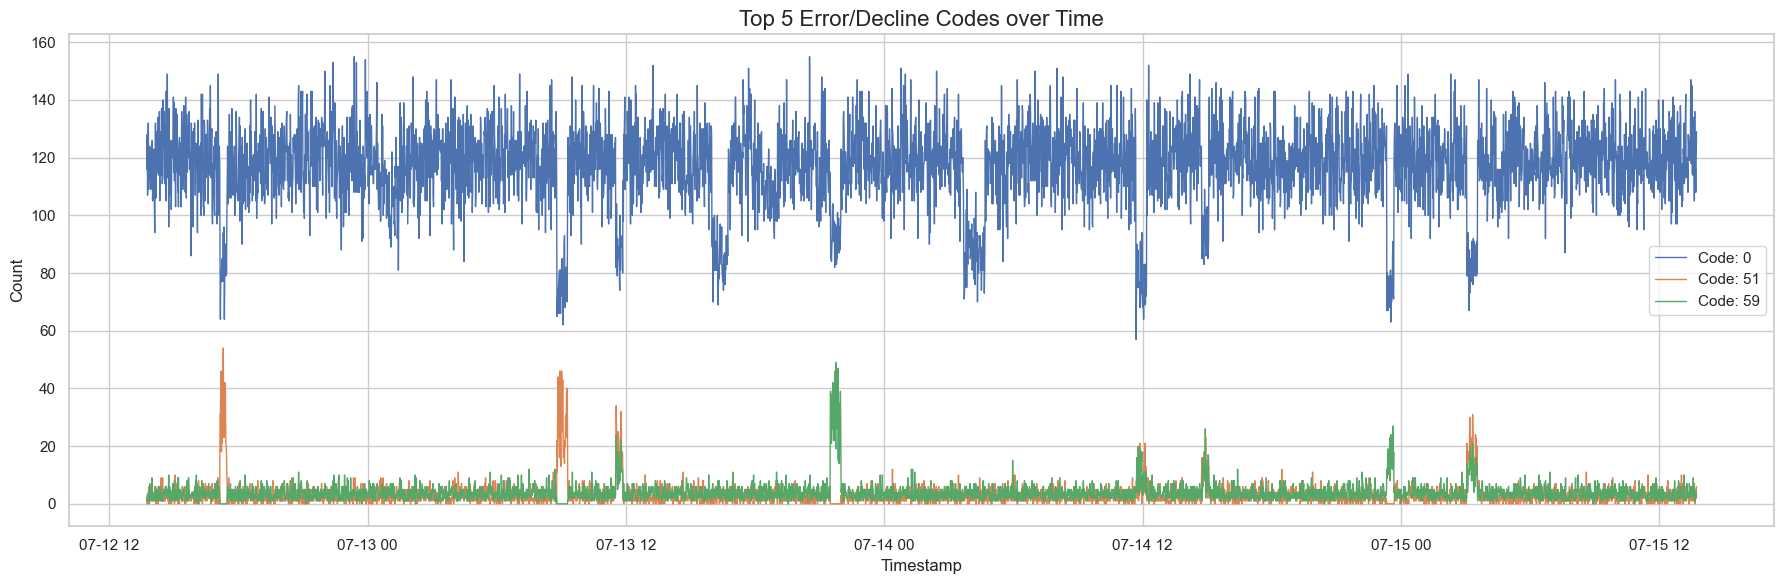

In [10]:
# Time series for top 5 non-approved auth codes
# Exclude '00' (Success) to focus on errors/declines
top_error_codes = df_auth[df_auth['auth_code'] != '00'].groupby('auth_code')['count'].sum().sort_values(ascending=False).head(5).index

error_pivot = df_auth[df_auth['auth_code'].isin(top_error_codes)].pivot_table(index='timestamp', columns='auth_code', values='count', aggfunc='sum', fill_value=0)

plt.figure(figsize=(18, 6))
for column in error_pivot.columns:
    plt.plot(error_pivot.index, error_pivot[column], label=f'Code: {column}', linewidth=1)

plt.title('Top 5 Error/Decline Codes over Time', fontsize=16)
plt.xlabel('Timestamp')
plt.ylabel('Count')
plt.legend()
plt.tight_layout()
plt.show()